# Chargement des données

Les données complètes sont disponibles sur le site http://jmcauley.ucsd.edu/data/amazon/links.html. Pour commencer, on se concentre sur des bases de données pour des catégories spécifiques de produit, afin d'avoir une taille raisonnable.

In [160]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import statistics as stat
from io import StringIO
import nltk
import sklearn

Tout d'abord, on sélectionne la catégorie de produit à étudier:

In [130]:
category_options={
    "Musical Instruments": "reviews_Musical_Instruments.json.gz",
    "Baby": "reviews_Baby.json.gz",
    "Movies and TV": "reviews_Movies_and_TV.json.gz",
}
dropdown = widgets.Dropdown(options=category_options, description="Catégorie de produit à étudier")
display(dropdown)

Ensuite, on décompresse le fichier pour obtenir un fichier en format json

In [131]:
if(not(os.path.isfile(dropdown.value[:-3]))):
    inputFile = gzip.open(dropdown.value, 'rb')
    outputFile = open(dropdown.value[:-3], 'wb')
    outputFile.write(inputFile.read())
    inputFile.close()
    outputFile.close()

On la transforme en Pandas DataFrame 

In [132]:
data=[]
filepath=dropdown.value[:-3]
with open(filepath) as f:
    for line in f:
        data.append(json.loads(line))
df=pd.DataFrame(data)

# Analyse descriptive

Regardons la structure de la table:

In [134]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0006428320,"[0, 0]",3,The portfolio is fine except for the fact that...,"03 11, 2014",A1YS9MDZP93857,John Taylor,Parts missing,1394496000
1,0014072149,"[0, 0]",5,If you are a serious violin student on a budge...,"06 6, 2013",A3TS466QBAWB9D,Silver Pencil,"Perform it with a friend, today!",1370476800
2,0041291905,"[0, 0]",5,This is and excellent edition and perfectly tr...,"10 14, 2013",A3BUDYITWUSIS7,joyce gabriel cornett,Vivalldi's Four Seasons,1381708800
3,0041913574,"[0, 0]",5,Perfect for someone who is an opera fan or a w...,"09 23, 2010",A19K10Z0D2NTZK,TexasCowboy,Full score: voice and orchestra,1285200000
4,0201891859,"[0, 1]",1,How many Nocturnes does it contain? All of the...,"10 17, 2012",A14X336IB4JD89,dfjm53,Unable to determine contents,1350432000


Etudions les dimensions clés de la table:

In [133]:
Nbreviews=len(df)
Nbproducts=len(set(df["asin"]))
Nbreviewers=len(set(df["reviewerID"]))
print("Le nombre total de reviews est: "+str(Nbreviews))
print("Le nombre total de produits est: "+str(Nbproducts))
print("Le nombre total de reviewers est: "+str(Nbreviewers))
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbproducts,1))+ " reviews par produit")
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbreviewers,1))+ " reviews par reviewers")

Le nombre total de reviews est: 500183
Le nombre total de produits est: 83048
Le nombre total de reviewers est: 339235
Soit un nombre moyen de 6.0 reviews par produit
Soit un nombre moyen de 1.5 reviews par reviewers


Analysons la distribution des notes des reviews

count    500183.000000
mean          4.244361
std           1.203369
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64


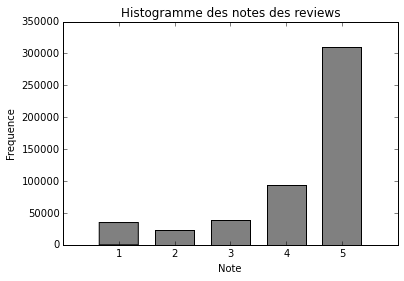

In [135]:
print(df["overall"].describe())
%matplotlib inline 
a=[int(i) for i in df["overall"]]
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes des reviews");
plt.xlabel("Note");
plt.ylabel("Frequence");

Regardons la distribution des notes moyennes par produit. On constate que la distribution est moins "skewed" que précedemment.

            overall
count  64426.000000
mean       4.062579
std        1.021886
min        1.000000
25%        3.589744
50%        4.333333
75%        5.000000
max        5.000000


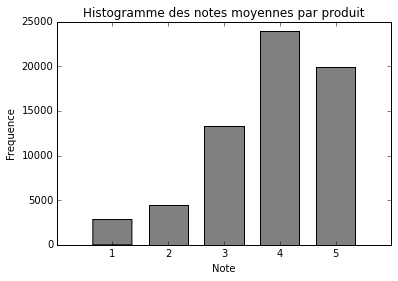

In [107]:
average_note_byproduct=df[["asin","overall"]].groupby("asin", as_index=False).mean()
print(average_note_byproduct.describe())
%matplotlib inline 
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(average_note_byproduct["overall"], bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes moyennes par produit");
plt.xlabel("Note");
plt.ylabel("Frequence");

Regardons la distribution du nombre de reviews par utilisateur.

                   0
count  339235.000000
mean        1.474444
std         2.342596
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       483.000000


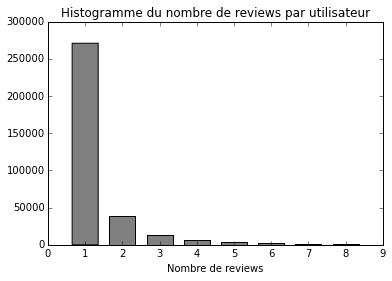

In [136]:
import collections
Nbreview_by_user=collections.Counter(df["reviewerID"])
print(pd.DataFrame(list(Nbreview_by_user.values())).describe())
bins=range(1,10,1)
a = np.clip(list(Nbreview_by_user.values()), 1, 10)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de reviews par utilisateur");
plt.xlabel("Nombre de reviews");
plt.ylabel("");

Définition de la fonction de comptage du nombre de mots d'une review

In [137]:
import re
def countWords(review):
    return (len(re.findall(r'\w+', review["reviewText"])))

In [138]:
df["countWordsReview"] = df.apply(countWords, axis = 1)

In [114]:
a = df["countWordsReview"]
print(max(a), min(a), stat.median(a), stat.mean(a))

4653 0 56.0 84.2634917549


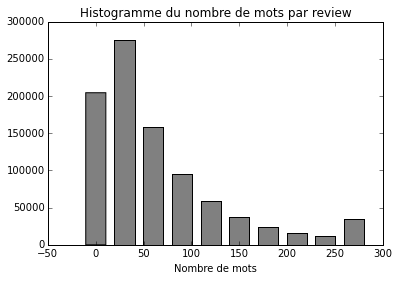

In [115]:
%matplotlib inline 
bins=range(0,330,30)
a = np.clip(df["countWordsReview"], 0, 300)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
##ax.set_xticks(bins[:-1])
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("");

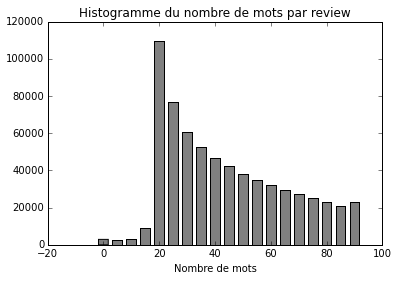

In [116]:
a = [s for s in df["countWordsReview"] if s < 101]
%matplotlib inline 
bins=range(0,100,5)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
##ax.set_xticks(bins[:-1])
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("");

In [118]:
#buf = StringIO()
#for i in range(df.shape[0]):
    #buf.write(df["reviewText"][i])

Regardons les dates de nos reviews. Cela nécessite une conversion du format UNIX au format data

In [128]:
from datetime import datetime
df["StandardReviewTime"] = df["unixReviewTime"].apply(datetime.fromtimestamp)
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,countWordsReview,StandardReviewTime
0,0188399313,"[0, 0]",5,"They work very well. Easy to clean, we wash th...","05 27, 2013",A28O3NP6WR5517,Jennifer gymer,These bottles are great!,1369612800,37,2013-05-27 02:00:00
1,0188399399,"[1, 1]",5,it came early and was not disappointed. i love...,"04 9, 2013",AX0M1Z6ZWO52J,Ash M.,perfect,1365465600,30,2013-04-09 02:00:00
2,0188399518,"[0, 0]",4,I ended up with a variety of different brands ...,"02 14, 2014",A1KD7N84L7NIUT,Buffy Fan,Good cotton wipes,1392336000,163,2014-02-14 01:00:00
3,0188399518,"[1, 1]",3,"These flannel wipes are OK, but in my opinion ...","07 8, 2013",A29CUDEIF4X1UO,J. D. Solbach,Sending them back.,1373241600,81,2013-07-08 02:00:00
4,0316967297,"[0, 0]",4,"Cute quilt, the colors are perfect and my litt...","09 6, 2013",A32592TYN6C9EM,Amazon Customer,Very cute,1378425600,21,2013-09-06 02:00:00


# Préparation des données

In [155]:
#Meh... Does not work yet
#nltk.download()
#all_words = nltk.FreqDist(w.lower() for w in nltk.word_tokenize(list(df["summary"]))) Does not work yet

In [167]:
#Meh... Still not working
#from sklearn.feature_extraction.text import CountVectorizer
#X_train_counts = sklearn.CountVectorizer.fit_transform(list(df["summary"]))
#X_train_counts.shape

AttributeError: 'module' object has no attribute 'CountVectorizer'